# A basic test script to practice EEG analysis

## Need to add MNE-Python and ANLffr to pythonpath first

In [1]:
import sys
import warnings

In [2]:
sys.path.append('/Users/hari/repos/mne-python/')
sys.path.append('/Users/hari/repos/ANLffr/')

## Now import MNE and ANLffr and proceed to load a dataset from current folder

In [3]:
import mne
from anlffr.helper import biosemi2mne as bs
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi']  = 120

In [4]:
raw, eves = bs.importbdf('/Users/hari/Dropbox/SNAPlabTraining/EEG/SampleData/I14_newatt.bdf')

Extracting EDF parameters from /Users/hari/Dropbox/SNAPlabTraining/EEG/SampleData/I14_newatt.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5277695  =      0.000 ...  2577.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom EEG reference.
Trigger channel has a non-zero initial value of 69376 (consider using initial_event=True to detect this event)
1485 events found
Event IDs: [ 1  2  3  5  7  9 15]


## Preprocessing

### Typical preprocessing steps include

- **Re-referencing** to an approriate channel or combination of channels (already done to earlobes)
- **Filter** the data to an appropriate frequency range. This will of course depend on the nature of the response. For ABRs, something like 50 -- 3000 Hz is typical. For cortical evoked potentials, something like 1 -- 40 Hz is typical. For ASSRs/EFRs, this would be based on the modulations eliciting the phase-locked response.
- If leaving low-frequencies intact, **eye blinks and saccades** are one prominent source of artifact. These will need to be suppressed (more below). 
- **Movement artifacts** occur intermittently and are large. So it is typical to exclude epochs of data containing large voltage excursions
- **EMG artifacts** from facial muscles (e.g., teeth clenching, squinting) or neck muscles (e.g., subject in an uncomfortable position) are usually small with appropriate subject instructions and providing comfortable seating. These are also relatively fast (dominant energy being in the 50 -- 200 Hz range). Thus they can be reduced by triggered averaging when cortical evoked potentials are of interest (i.e., 1 -- 40 Hz).

## Let's start with filtering


In [5]:
raw.filter(1., 40.)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6759 samples (3.300 sec)



<RawEDF | I14_newatt.bdf, 41 x 5277696 (2577.0 s), ~1.61 GB, data loaded>

## Detect blinks using one of the forehead channels (let's use A1) and then use it to remove blink artifacts using SSP

In [6]:
from anlffr.preproc import find_blinks
blinks = find_blinks(raw)

Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.42 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 45057 samples (22.000 sec)



In [7]:
from mne import compute_proj_epochs
epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                           reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)

Not setting metadata
Not setting metadata
1052 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [8]:
blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=2)

    Rejecting  epoch based on EEG : ['A6', 'A25']
    Rejecting  epoch based on EEG : ['A15', 'A16', 'A17']
    Rejecting  epoch based on EEG : ['A2']
    Rejecting  epoch based on EEG : ['A21']
No gradiometers found. Forcing n_grad to 0
No magnetometers found. Forcing n_mag to 0
Adding projection: eeg-998--0.250-0.250-PCA-01
Adding projection: eeg-998--0.250-0.250-PCA-02


In [9]:
raw.add_proj(blink_proj)

2 projection items deactivated


<RawEDF | I14_newatt.bdf, 41 x 5277696 (2577.0 s), ~1.61 GB, data loaded>

## Visualize the spatial filter created by SSP

SSP creates a spatial vector (i.e., weightings across channels) that would best capture the artifact variance. This vector can be visualized by plotting the weights as a scalp topographic map (a.k.a. topomap). To remove the artifacts, the EEG data will then be project to the subspace orthogonal to the SSP vectors. Here, we requested MNE to compute two SSP, both from samples surrounding the blinks. Because saccades often co-occur or close to blinks, SSP will typically identify the spatial patterns of both the blink and saccade artifacts. The topomaps obtained should be consistent with the expected patterns for those two sources of artifact.

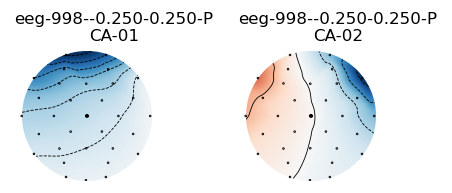

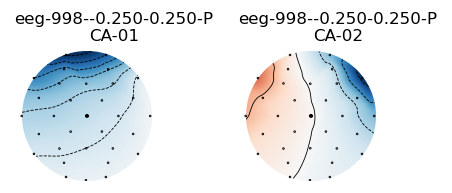

In [10]:
raw.plot_projs_topomap()

## Epoching
Once the blink projectors are identified, they can be applied at anytime. Now let's segment the continuous EEG recording into small epochs that will allow for triggered averaging. For this task paradigm, ```event_id=1``` corresponds to the onset of sound. Let's start with that to see if we can get auditory evoked responses.

In [11]:
epochs = mne.Epochs(raw, eves, event_id=1, baseline=(-0.5, 0.), proj=True,
                    tmin=-0.5, tmax=2.5, reject=dict(eeg=200e-6))

Not setting metadata
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated


## Averaging
Now that we have segmented our EEG signal synchronously with the sound onset events, we can perform (triggered) averaging so reduce all signals that are *not* phase locked to this event so that the auditory evoked potential survives. We can then plot the reponse from the 32 channels.

In [12]:
evoked = epochs.average()

    Rejecting  epoch based on EEG : ['A25']
    Rejecting  epoch based on EEG : ['A1', 'A30']
    Rejecting  epoch based on EEG : ['A2']
    Rejecting  epoch based on EEG : ['A14']
    Rejecting  epoch based on EEG : ['A14']
    Rejecting  epoch based on EEG : ['A2']


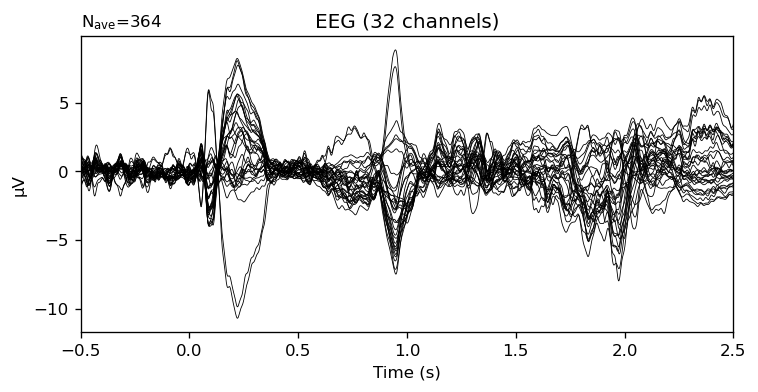

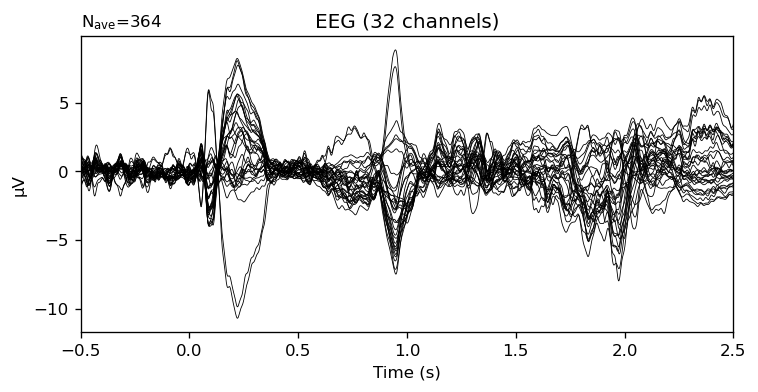

In [13]:
evoked.plot()

## Visualizing the spatial configuration of the auditory evoked response
In the time plots, clear excursions peaking around 100 and 200 ms after the onset of the sound are apparent. These are referred to the N1 and P2 components, respectively. We can get a sense of the location of the underlying source of these components by visualizing them as a topomap (again). Let's look at the larger P2 response, which typically occurs around 220 ms.

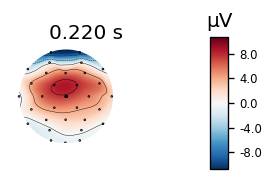

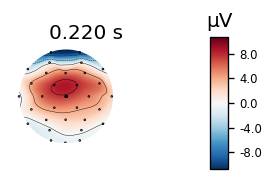

In [14]:
evoked.plot_topomap(0.220)

## Now, let's try some induced rhythms analysis
Each trial consists of a cue (tigger 3 or 5), and then 2-second gap, followed by sound (trigger 1). Let's epoch based on the visual cue and look for alpha activity associated with orienting of attention.

In [15]:
epochs_cue = mne.Epochs(raw, eves, event_id=[3, 5], baseline=(-0.5, 0.), proj=True,
                        tmin=-0.5, tmax=4.5, reject=dict(eeg=100e-6))

Not setting metadata
Not setting metadata
370 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated


In [16]:
import numpy as np
freqs = np.arange(4., 40., 2.)
n_cycles = freqs * 0.4

In [17]:
from mne.time_frequency import tfr_multitaper

In [18]:
power = tfr_multitaper(epochs_cue, freqs, n_cycles, return_itc=False, picks=[17])  # Compute for one channel

Loading data for 370 events and 10241 original time points ...
    Rejecting  epoch based on EEG : ['A1', 'A16', 'A17', 'A30']
    Rejecting  epoch based on EEG : ['A1']
    Rejecting  epoch based on EEG : ['A1', 'A11', 'A14', 'A15', 'A16', 'A17', 'A18', 'A20', 'A30']
    Rejecting  epoch based on EEG : ['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A30']
    Rejecting  epoch based on EEG : ['A1', 'A16', 'A17', 'A18', 'A30']
    Rejecting  epoch based on EEG : ['A14']
    Rejecting  epoch based on EEG : ['A1', 'A10', 'A30']
    Rejecting  epoch based on EEG : ['A1', 'A14', 'A15', 'A16', 'A17', 'A18', 'A30']
    Rejecting  epoch based on EEG : ['A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A21', 'A23', 'A24', 'A25', 'A28', 'A30']
    Rejecting  epoch based on EEG : ['A15']
    Rejecting  epoch based on EEG : ['A16']
    Rejecting  epoch based on EEG : ['A1', 'A30']
    Rejecting  epoch based on EEG : ['A1', 'A3', 'A4',

Applying baseline correction (mode: zlogratio)


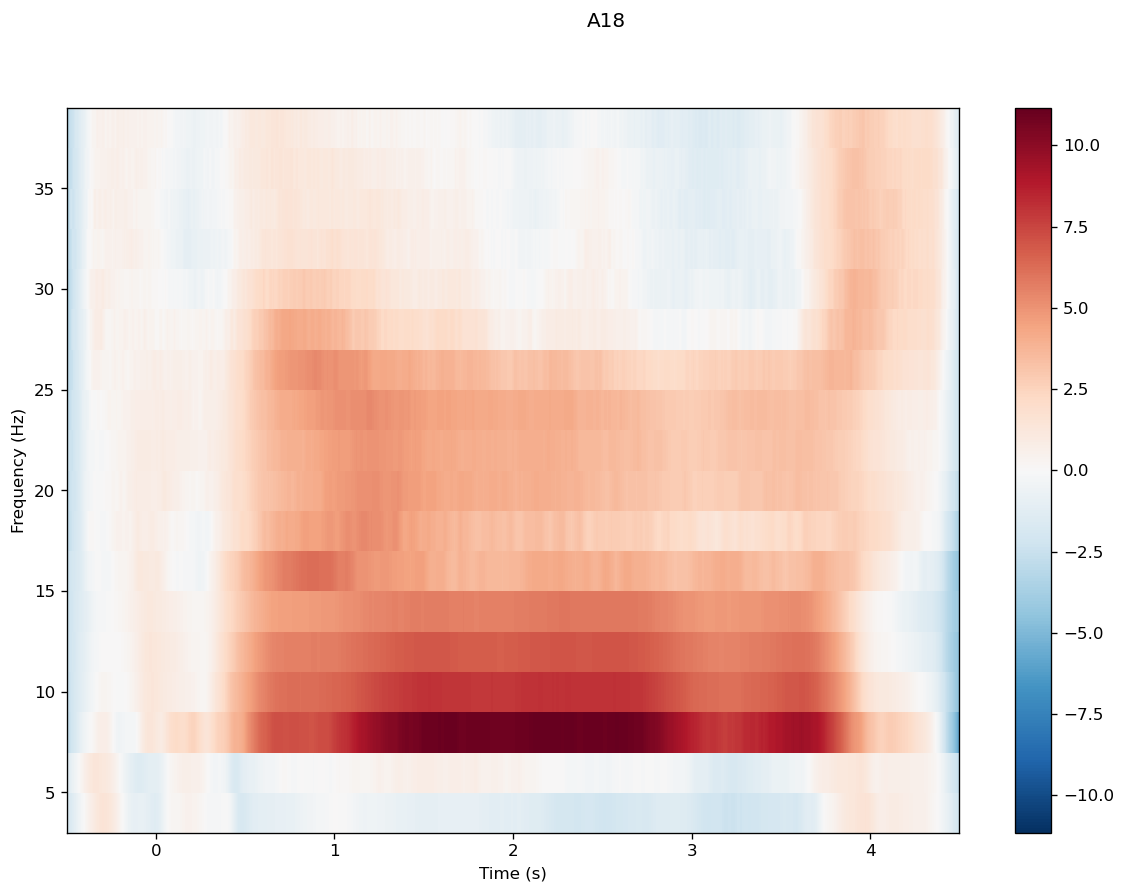

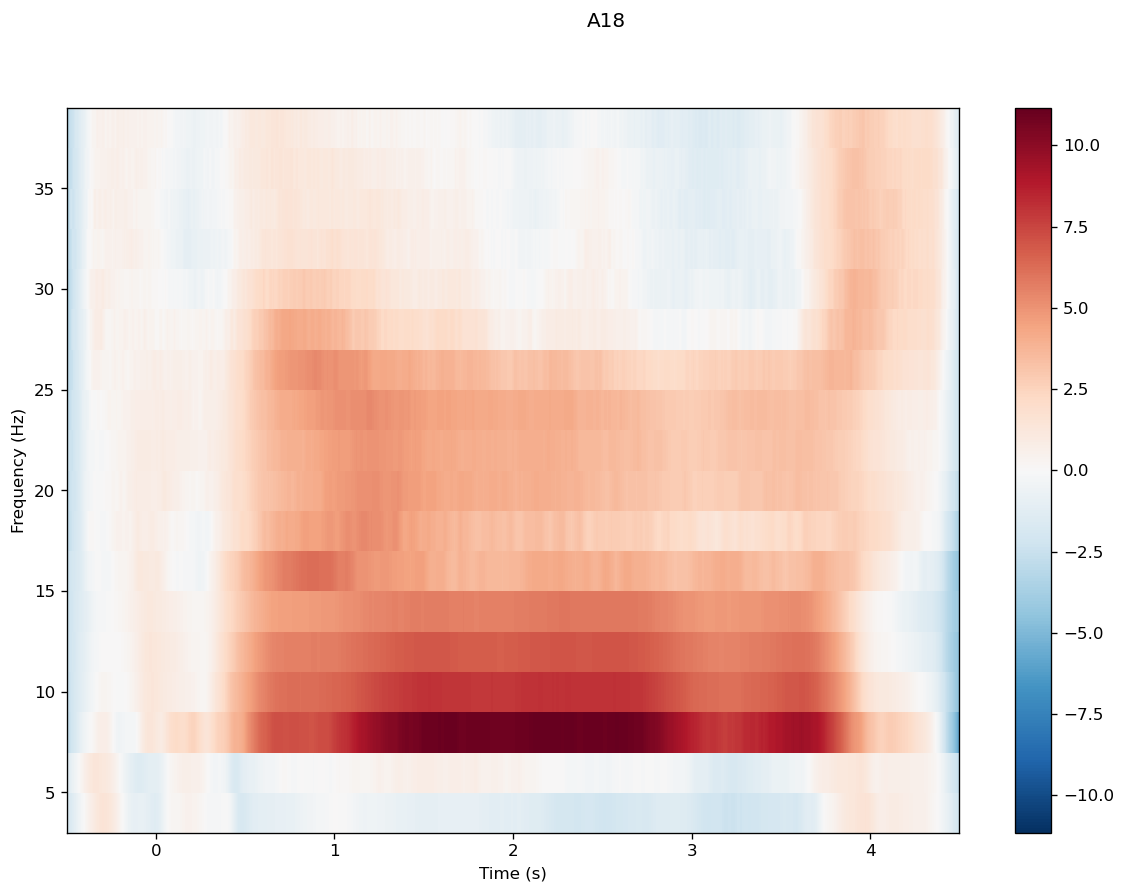

In [19]:
power.plot(picks=[0], baseline=(-0.5, 0.), mode='zlogratio')

## Examine the phase-locked response to the cue, i.e., the evoked response to the visual cue itself

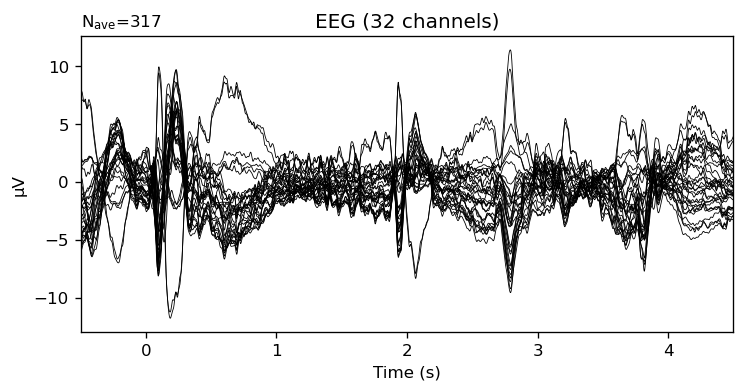

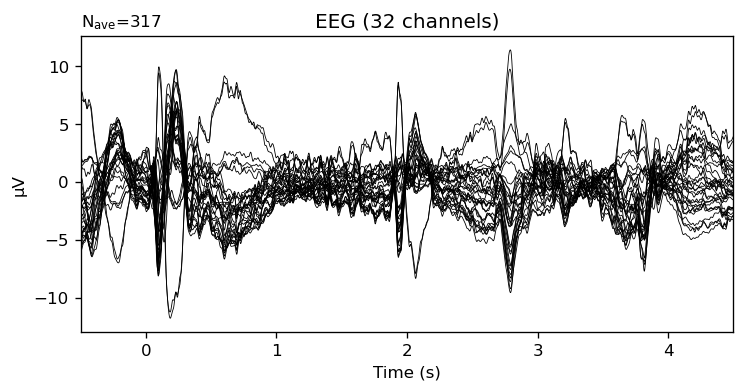

In [20]:
evoked_cue = epochs_cue.average()
evoked_cue.plot()

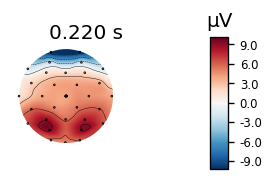

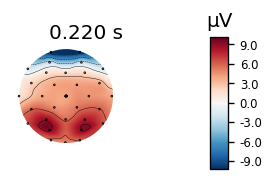

In [21]:
evoked_cue.plot_topomap(0.220)